# Exploring 2020 US election tweet sentiment: analysis based on big data and machine learning


This project utilized Apache Spark and MLib to conduct in-depth analysis and sentiment prediction on Twitter data during the 2020 US presidential election. 


### Team 18: 
Cheng Yan, Xuanhong Luo, Wenchao Xia, Shangkai Jiang, Chengkai Wang, Wentong Du

# Steps:

###### 1.Loading and preprocessing the data:

* Load data from a CSV file.
* View missing values of data and delete rows containing missing values.
* Clean up the content of tweets to reduce data noise.
* Using natural language processing and sentient analysis algorithms, classify tweets into different types of sentiments

###### 2.Feature engineering:

- Using TF-IDF for Feature Extraction of Text

###### 3.Create a model and compare multiple model metrics

- Use different machine learning models to train and predict Twitter data, and use the accuracy, recall, F1 score, and other indicators of different models to compare each model. 

###### 4.Prediction on the test set

- Make predictions on the test set and print model metrics.


In [0]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, LongType, TimestampType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
import re
import string
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, LinearSVC
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
# install TextBlob
%pip install textblob
# install nltk
%pip install nltk
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Not uninstalling nltk at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1de8568c-2eb1-4d4c-af66-5e49cb269730
    Can't uninstall 'nltk'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# code source https://stackoverflow.com/questions/30461969/disable-default-certificate-verification-in-python-2-7-9

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 1.Loading and preprocessing the data:

#### 1.1 Use spark to read the data

In [0]:
# Reading data using spark
spark = SparkSession.builder.appName('tweets_sentiment').getOrCreate()


# Define the file format and column format in the csv, 
# direct reading will result in a lot of data being null
schema = StructType([
    StructField("created_at", TimestampType(), True),
    StructField("tweet_id", StringType(), True),
    StructField("tweet", StringType(), True),
    StructField("likes", FloatType(), True),
    StructField("retweet_count", FloatType(), True),
    StructField("source", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("user_name", StringType(), True),
    StructField("user_screen_name", StringType(), True),
    StructField("user_description", StringType(), True),
    StructField("user_join_date", TimestampType(), True),
    StructField("user_followers_count", FloatType(), True),
    StructField("user_location", StringType(), True),
    StructField("lat", FloatType(), True),
    StructField("long", FloatType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True),
    StructField("continent", StringType(), True),
    StructField("state", StringType(), True),
    StructField("state_code", StringType(), True),
    StructField("collected_at", TimestampType(), True)
])
df1 = spark.read \
    .option("header", "true") \
    .option("multiline", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("dateFormat", "yyyy-MM-dd HH:mm:ss") \
    .schema(schema) \
    .csv("/mnt/2024-team18/sample_donaldtrump.csv") 

df2 = spark.read \
    .option("header", "true") \
    .option("multiline", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("dateFormat", "yyyy-MM-dd HH:mm:ss") \
    .schema(schema) \
    .csv("/mnt/2024-team18/sample_joebiden.csv") 

In [0]:
# covert to dataframe
df1 = df1.toDF(*df1.columns)
df2 = df2.toDF(*df2.columns)

df1.cache()
df2.cache()

DataFrame[created_at: timestamp, tweet_id: string, tweet: string, likes: float, retweet_count: float, source: string, user_id: string, user_name: string, user_screen_name: string, user_description: string, user_join_date: timestamp, user_followers_count: float, user_location: string, lat: float, long: float, city: string, country: string, continent: string, state: string, state_code: string, collected_at: timestamp]

#### 1.2 Drop useless columns and drop rows with missing values

In [0]:
# Clean the data
# Data preprocessing, removing useless columns and retaining eigenvalues
# Column names to be removed
drop_names = ['created_at', 'tweet_id', 'source', 'likes', 'retweet_count', 'user_followers_count', 'user_location', 'lat', 'long', 'city', 'user_id', 'user_name', 'user_screen_name', 'user_description', 'user_join_date', 'state_code', 'continent', 'collected_at']

# drop useless columns
df1 = df1.drop(*drop_names)
df2 = df2.drop(*drop_names)

# view missing values, 
# df1.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df1.columns]).show()
# df2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

In [0]:
# drop na rows
df1 = df1.dropna()
df2 = df2.dropna()

In [0]:
# # only use 10% of the data for testing
# df1 = df1.sample(False, 0.1, seed=22)
# df2 = df2.sample(False, 0.1, seed=22)

#### 1.3 Clean up the content of tweets to reduce data noise

In [0]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# def clean_text code source
# https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet
# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate

# clean tweets text
def clean_text(tweet):
    # to lower case
    tweet = tweet.lower()
    # remove http
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # remove punctuation mark
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # remove number
    tweet = re.sub(r'\d+', '', tweet)
    # remove strip
    tweet = tweet.strip()
    # remove emoji
    tweet = re.sub(r'[^\w\s,]', '', tweet)
    # remove stopping words
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

# def analyze_sentiment code source
# https://github.com/explosion/spaCy/discussions/12401

# use TextBlob get sentiment polarity
def analyze_sentiment(tweet):
    blob = TextBlob(tweet)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0.5:
        return "positive"
    elif sentiment_score < -0.5:
        return "negative"
    else:
        return "neutral"

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spark-1de8568c-2eb1-4d4c-af66-5e/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# clean tweets text
udf_t = udf(clean_text, StringType())

df1 = df1.withColumn("cleaned_tweet", udf_t(df1["tweet"]))
df2 = df2.withColumn("cleaned_tweet", udf_t(df2["tweet"]))

df1 = df1.drop('tweet')
df2 = df2.drop('tweet')

# # save cleaned data
# df1.write.mode("overwrite").csv("cleaned_donaldtrump.csv")
# df2.write.mode("overwrite").csv("cleaned_joebiden.csv")

#### 1.4 Using natural language processing and sentient analysis algorithms, classify tweets into different types of sentiments

In [0]:
# Creating a Sentiment Analysis UDF
udf_s = F.udf(analyze_sentiment, StringType())

# Convert df1 and df2 for sentiment analysis and add columns
df1 = df1.withColumn('sentiment', udf_s(df1['cleaned_tweet'])).withColumn('candidate', F.lit('donaldtrump'))
df2 = df2.withColumn('sentiment', udf_s(df2['cleaned_tweet'])).withColumn('candidate', F.lit('joebiden'))

# merge df1 and df2
df = df1.union(df2)

# cache data
df.cache()


DataFrame[country: string, state: string, cleaned_tweet: string, sentiment: string, candidate: string]

### 2.Feature engineering:

- Using TF-IDF for Feature Extraction of Text

In [0]:
# Convert sentiment labels to numeric values
indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
df = indexer.fit(df).transform(df)
    
# Create a splitter
tokenizer = Tokenizer(inputCol="cleaned_tweet", outputCol="words")
# Create feature hashers
# Manually adjust the parameters many times to run the comparison results, 
# when numFeatures = 80000 , accuracy is high and running time is good 
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=80000)
# Create IDF
idf_features = IDF(inputCol="raw_features", outputCol="features")


In [0]:
SEED = 22
# Split the dataset into training and test sets and increase the number of partitions in the training set
train = df.randomSplit([0.8, 0.2], seed=SEED)[0].repartition(4).cache()
test = df.randomSplit([0.8, 0.2], seed=SEED)[1].repartition(4)

### 3.Create a model and compare multiple model metrics

#### 3.1 Logistic Regression

In [0]:
# start time
start_time = time.time()

# Define the logistic regression classifier
lr = LogisticRegression(labelCol="sentiment_index", featuresCol="features", maxIter=50, regParam=0.01)

# Create Pipeline
pipeline_lr = Pipeline(stages=[ tokenizer, hashingTF, idf_features, lr])

# # grid search and cross validation
# paramGrid = ParamGridBuilder() \
#     .addGrid(lr.maxIter, [10, 50, 100]) \
#     .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
#     .build()
# evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
# crossval = CrossValidator(estimator=pipeline_lr,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)
# cvModel = crossval.fit(train)
# predictions = cvModel.transform(test)
# accuracy_lr = evaluator.evaluate(predictions)
# print("Accuracy: " + str(accuracy_lr))
# # print best model param
# bestModel_lr = cvModel.bestModel
# print("Best Param (regParam): ", bestModel_lr.stages[-1]._java_obj.getRegParam())
# print("Best Param (maxIter): ", bestModel_lr.stages[-1]._java_obj.getMaxIter())

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")

model_lr = pipeline_lr.fit(train)
predictions = model_lr.transform(test)

accuracy_lr = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy_lr))

recall_lr = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="weightedRecall")
recall_score_lr = recall_lr.evaluate(predictions)
print("Recall:", recall_score_lr)

f1_lr = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="f1")
f1_score_lr = f1_lr.evaluate(predictions)
print("F1 Score:", f1_score_lr)


# end time
end_time = time.time()
runtime_lr = end_time - start_time
print("Time:", runtime_lr)

# # Load Model
#model_lr = PipelineModel.load("/mnt/2024-team18/tsa_logistic_regression_model_V1")

# Save Model
# model_lr.write().overwrite().save("/mnt/2024-team18/tsa_logistic_regression_model_V1")

Accuracy: 0.9405405405405406
Recall: 0.9405405405405406
F1 Score: 0.9303455028958464
Time: 57.322437047958374


#### 3.2 Random Forest (Very long running time, not recommended)

In [0]:
start_time = time.time()

rf = RandomForestClassifier(labelCol="sentiment_index", featuresCol="features", numTrees=80, maxDepth=10)

pipeline_rf = Pipeline(stages=[tokenizer, hashingTF, idf_features, rf])

# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 20, 30]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .build()
# evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
# crossval = CrossValidator(estimator=pipeline_rf,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)
# cvModel = crossval.fit(train)
# predictions = cvModel.transform(test)
# accuracy_rf = evaluator.evaluate(predictions)
# print("Accuracy: " + str(accuracy_rf))
# # print best model param
# bestModel_rf = cvModel.bestModel
# print("Best Param (numTrees): ", bestModel_rf.stages[-1]._java_obj.getNumTrees())
# print("Best Param (maxDepth): ", bestModel_rf.stages[-1]._java_obj.getMaxDepth())

model_rf = pipeline_rf.fit(train)
predictions = model_rf.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy_rf))

recall_rf = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="weightedRecall")
recall_score_rf = recall_rf.evaluate(predictions)
print("Recall:", recall_score_rf)

f1_rf = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="f1")
f1_score_rf = f1_rf.evaluate(predictions)
print("F1 Score:", f1_score_rf)

end_time = time.time()
runtime_rf = end_time - start_time
print("Time:", runtime_rf)

Accuracy: 0.9292149292149292
Recall: 0.9292149292149292
F1 Score: 0.8951209858481374
Time: 301.83826661109924


#### 3.3 SVM-OneVsRest

In [0]:
from pyspark.ml.classification import OneVsRest

start_time = time.time()

svm = LinearSVC(maxIter=10, regParam=0.1)

# create OneVsRest 
ovr = OneVsRest(classifier=svm, labelCol="sentiment_index", featuresCol="features")

# create pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf_features, ovr])

bestModel_svm = pipeline.fit(train)

# predictions
predictions = bestModel_svm.transform(test)

# accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
accuracy_svm = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy_svm))

recall_svm = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="weightedRecall")
recall_score_svm = recall_svm.evaluate(predictions)
print("Recall:", recall_score_svm)

f1_svm = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="f1")
f1_score_svm = f1_svm.evaluate(predictions)
print("F1 Score:", f1_score_svm)

end_time = time.time()
runtime_svm = end_time - start_time
print("Time:", runtime_svm)

Accuracy: 0.9312741312741313
Recall: 0.9312741312741313
F1 Score: 0.9148246704955151
Time: 140.84813475608826


#### 3.4 Naive Bayes

In [0]:
start_time = time.time()

nb = NaiveBayes(labelCol="sentiment_index", featuresCol="features")

pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf_features, nb])

# paramGrid = ParamGridBuilder() \
#     .addGrid(nb.smoothing, [0.0, 0.2, 0.4]) \
#     .build()
# 
# evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
# 
# crossval = CrossValidator(estimator=pipeline_nb,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)
# 
# cvModel = crossval.fit(train)
# 
# predictions = cvModel.transform(test)
# accuracy_nb = evaluator.evaluate(predictions)
# print("Test set accuracy = " + str(accuracy_nb))
# # print best model param
# bestModel_nb = cvModel.bestModel
# print("Best Param (smoothing): ", bestModel_nb.stages[-1]._java_obj.getSmoothing())

model_nb = pipeline_nb.fit(train)
predictions = model_nb.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
accuracy_nb = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy_nb))

recall_nb = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="weightedRecall")
recall_score_nb = recall_nb.evaluate(predictions)
print("Recall:", recall_score_nb)

f1_nb = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="f1")
f1_score_nb = f1_nb.evaluate(predictions)
print("F1 Score:", f1_score_nb)

end_time = time.time()
runtime_nb = end_time - start_time
print("Time:", runtime_nb)

Accuracy: 0.8015444015444015
Recall: 0.8015444015444015
F1 Score: 0.8434892134307804
Time: 44.14728903770447


#### 3.5 Model comparison

Logistic Regression: Accuracy:  0.9405405405405406 Runtime:  57.322437047958374 Recall:  0.9405405405405406 F1 Score:  0.9303455028958464
SVM-OneVsRest: Accuracy:  0.9312741312741313 Runtime:  140.84813475608826 Recall:  0.9312741312741313 F1 Score:  0.9148246704955151
Naive Bayes: Accuracy:  0.8015444015444015 Runtime:  44.14728903770447 Recall:  0.8015444015444015 F1 Score:  0.8434892134307804
Random Forest: Accuracy:  0.9292149292149292 Runtime:  301.83826661109924 Recall:  0.9292149292149292 F1 Score:  0.8951209858481374


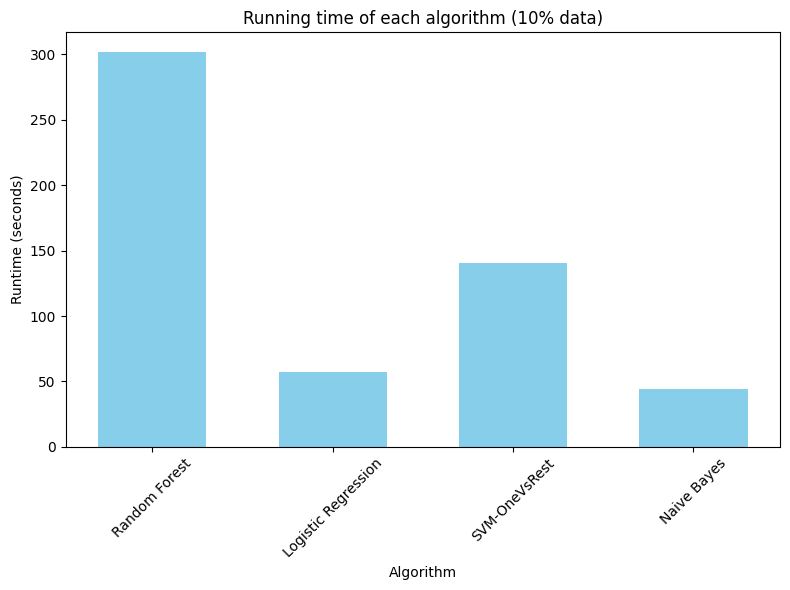

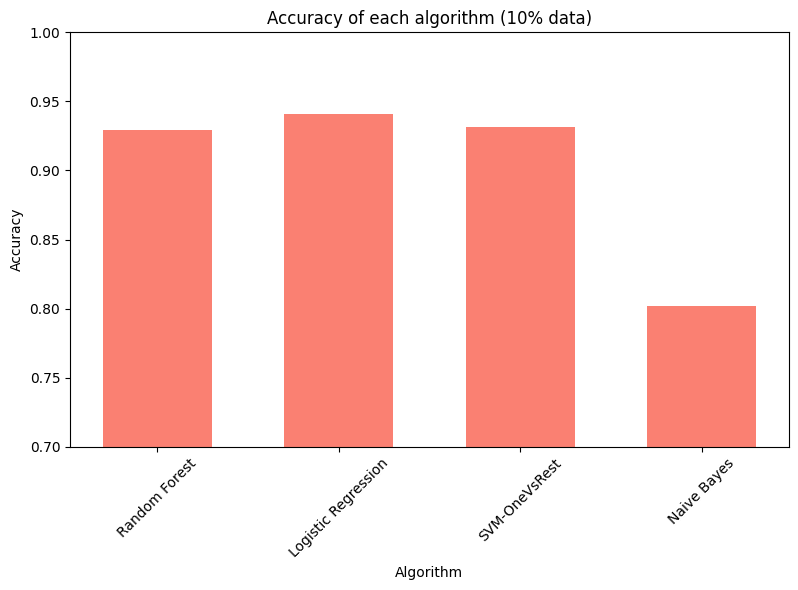

In [0]:
# Compare different models
# show runtime and accuracy and  recall and f1 score of each model
print("Logistic Regression: Accuracy: ", accuracy_lr, "Runtime: ", runtime_lr, "Recall: ", recall_score_lr, "F1 Score: ", f1_score_lr)
print("SVM-OneVsRest: Accuracy: ", accuracy_svm, "Runtime: ", runtime_svm, "Recall: ", recall_score_svm, "F1 Score: ", f1_score_svm)
print("Naive Bayes: Accuracy: ", accuracy_nb, "Runtime: ", runtime_nb, "Recall: ", recall_score_nb, "F1 Score: ", f1_score_nb)
print("Random Forest: Accuracy: ", accuracy_rf, "Runtime: ", runtime_rf, "Recall: ", recall_score_rf, "F1 Score: ", f1_score_rf)

# plot
models = ['Random Forest', 'Logistic Regression', 'SVM-OneVsRest', 'Naive Bayes']
accuracy = [accuracy_rf, accuracy_lr, accuracy_svm, accuracy_nb]
runtime = [runtime_rf, runtime_lr, runtime_svm, runtime_nb]


bar_width = 0.6
# plot runtime bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, runtime, color='skyblue', width=bar_width)
plt.title('Running time of each algorithm (10% data)')
plt.xlabel('Algorithm')
plt.ylabel('Runtime (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot accuracy bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color='salmon', width=bar_width)
plt.title('Accuracy of each algorithm (10% data)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0.7, 1)
plt.show()


#### 3.6 Scalability of Logistic Regression(Long execution time, only releasing comments during testing)

In [0]:
# spark = SparkSession.builder.appName('tweets_sentiment_test00001x_V1').getOrCreate()
# nltk.download('stopwords')

In [0]:
# def df_process(percentage):
#     # Reading data using spark
    
#     # Define the file format and column format in the csv, 
#     # direct reading will result in a lot of data being null
#     schema = StructType([
#         StructField("created_at", TimestampType(), True),
#         StructField("tweet_id", StringType(), True),
#         StructField("tweet", StringType(), True),
#         StructField("likes", FloatType(), True),
#         StructField("retweet_count", FloatType(), True),
#         StructField("source", StringType(), True),
#         StructField("user_id", StringType(), True),
#         StructField("user_name", StringType(), True),
#         StructField("user_screen_name", StringType(), True),
#         StructField("user_description", StringType(), True),
#         StructField("user_join_date", TimestampType(), True),
#         StructField("user_followers_count", FloatType(), True),
#         StructField("user_location", StringType(), True),
#         StructField("lat", FloatType(), True),
#         StructField("long", FloatType(), True),
#         StructField("city", StringType(), True),
#         StructField("country", StringType(), True),
#         StructField("continent", StringType(), True),
#         StructField("state", StringType(), True),
#         StructField("state_code", StringType(), True),
#         StructField("collected_at", TimestampType(), True)
#     ])
#     df1 = spark.read \
#         .option("header", "true") \
#         .option("multiline", "true") \
#         .option("quote", "\"") \
#         .option("escape", "\"") \
#         .option("dateFormat", "yyyy-MM-dd HH:mm:ss") \
#         .schema(schema) \
#         .csv("/mnt/2024-team18/sample_donaldtrump.csv") 
    
#     df2 = spark.read \
#         .option("header", "true") \
#         .option("multiline", "true") \
#         .option("quote", "\"") \
#         .option("escape", "\"") \
#         .option("dateFormat", "yyyy-MM-dd HH:mm:ss") \
#         .schema(schema) \
#         .csv("/mnt/2024-team18/sample_joebiden.csv") 
#     # Parallel conversion to DataFrame
#     df1 = spark.createDataFrame(df1.rdd, schema)
#     df2 = spark.createDataFrame(df2.rdd, schema)
    
#     df1 = df1.sample(False, percentage, seed=22)
#     df2 = df2.sample(False, percentage, seed=22)
    
#     df1.cache()
#     df2.cache()
#     drop_names = ['created_at', 'tweet_id', 'source', 'likes', 'retweet_count', 'user_followers_count', 'user_location', 'lat', 'long', 'city', 'user_id', 'user_name', 'user_screen_name', 'user_description', 'user_join_date', 'state_code', 'continent', 'collected_at']
    
#     # drop useless columns
#     df1 = df1.drop(*drop_names)
#     df2 = df2.drop(*drop_names)
    
#     # drop na rows
#     df1 = df1.dropna()
#     df2 = df2.dropna()


#     stop_words = set(stopwords.words('english'))
    
#     # clean tweets text
#     def clean_text(tweet):
#         # to lower case
#         tweet = tweet.lower()
#         # remove http
#         tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
#         # remove punctuation mark
#         tweet = tweet.translate(str.maketrans('', '', string.punctuation))
#         # remove number
#         tweet = re.sub(r'\d+', '', tweet)
#         # remove strip
#         tweet = tweet.strip()
#         # remove emoji
#         tweet = re.sub(r'[^\w\s,]', '', tweet)
#         # remove stopping words
#         tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
#         return tweet
    
#     # use TextBlob get sentiment polarity
#     def analyze_sentiment(tweet):
#         blob = TextBlob(tweet)
#         sentiment_score = blob.sentiment.polarity
#         if sentiment_score > 0.5:
#             return "positive"
#         elif sentiment_score < -0.5:
#             return "negative"
#         else:
#             return "neutral"
        
#     # clean tweets text
#     udf_t = udf(clean_text, StringType())
    
#     df1 = df1.withColumn("cleaned_tweet", udf_t(df1["tweet"]))
#     df2 = df2.withColumn("cleaned_tweet", udf_t(df2["tweet"]))
    
#     df1 = df1.drop('tweet')
#     df2 = df2.drop('tweet')
    
#     # Creating a Sentiment Analysis UDF
#     udf_s = F.udf(analyze_sentiment, StringType())
    
#     # Convert df1 and df2 for sentiment analysis and add columns
#     df1 = df1.withColumn('sentiment', udf_s(df1['cleaned_tweet'])).withColumn('candidate', F.lit('donaldtrump'))
#     df2 = df2.withColumn('sentiment', udf_s(df2['cleaned_tweet'])).withColumn('candidate', F.lit('joebiden'))
    
#     # merge df1 and df2
#     df = df1.union(df2)
    
#     # cache data
#     df.cache()
    
#     # Convert sentiment labels to numeric values
#     indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
#     df = indexer.fit(df).transform(df)
        
#     # Create a splitter
#     tokenizer = Tokenizer(inputCol="cleaned_tweet", outputCol="words")
#     # Create feature hashers
#     # Manually adjust the parameters many times to run the comparison results, 
#     # when numFeatures = 80000 , accuracy is high and running time is good 
#     hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=80000)
#     # Create IDF
#     idf_features = IDF(inputCol="raw_features", outputCol="features")
    
#     return df,tokenizer, hashingTF, idf_features


In [0]:
# # Logistic Regression
# running_time = []

# # Use for each to get different data sizes()df to test the scalability of Logistic Regression
# def logistic_regression(percentage):
#     start_time = time.time()
#     df, tokenizer, hashingTF, idf_features = df_process(percentage)

#     # Split the dataset into training and test sets and increase the number of partitions in the training set
#     train = df.randomSplit([0.8, 0.2], seed=22)[0].repartition(4).cache()
#     test = df.randomSplit([0.8, 0.2], seed=22)[1].repartition(4)

#     lr = LogisticRegression(labelCol="sentiment_index", featuresCol="features", maxIter=50, regParam=0.01)

#     # Create Pipeline
#     pipeline_lr = Pipeline(stages=[ tokenizer, hashingTF, idf_features, lr])
#     model_lr = pipeline_lr.fit(train)
#     predictions = model_lr.transform(test)
    
#     end_time = time.time()
#     runtime_lr = end_time - start_time
#     running_time.append(runtime_lr)
    
# for i in range(1, 11):
#     logistic_regression(i*0.1)
#     print("Data size: ", i*10, "%")
#     print("Running time: ", running_time[-1])
#     print("=====================================")

# # plot
# plt.figure(figsize=(8, 6))
# plt.plot(range(10, 101, 10), running_time, marker='o', color='skyblue')
# plt.title('Scalability of Logistic Regression')
# plt.xlabel('Data size (%)')
# plt.ylabel('Running time (seconds)')
# plt.xticks(range(10, 101, 10))
# plt.yticks(range(10,100, 10))
# plt.tight_layout()
# plt.show()


### 4.Prediction on the test set

In [0]:
# Apply logic regression model to test set
predictions_lr = model_lr.transform(test)
predictions_lr = predictions_lr.select(F.col("sentiment_index"), F.col("prediction"))
predictions_lr = predictions_lr.repartition(4)
predictions_lr.cache()

DataFrame[sentiment_index: double, prediction: double]

In [0]:
accuracy = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="accuracy")
accuracy_score = accuracy.evaluate(predictions_lr)
print("Accuracy:", accuracy_score)

recall = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="weightedRecall")
recall_score = recall.evaluate(predictions_lr)
print("Recall:", recall_score)

f1 = MulticlassClassificationEvaluator(labelCol="sentiment_index", predictionCol="prediction", metricName="f1")
f1_score = f1.evaluate(predictions_lr)
print("F1 Score:", f1_score)

Accuracy: 0.9405405405405406
Recall: 0.9405405405405406
F1 Score: 0.9303455028958464


In [0]:
df1.unpersist()
df2.unpersist()
df.unpersist()
predictions_lr.unpersist()

DataFrame[sentiment_index: double, prediction: double]